In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16
from keras.src.layers.pooling.average_pooling2d import AvgPool2D
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout
from keras.models import Sequential
from keras.layers import Dense,Input,Flatten
from tensorflow.keras.utils import load_img,img_to_array
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
from zipfile import ZipFile
import random
import shutil
from tqdm import tqdm

In [ ]:
def get_percent_images(target_dir, new_dir, sample_amount=0.1, random_state=42):
    """
    Get sample_amount percentage of random images from target_dir and copy them to new_dir.

    Preserves subdirectory file names.

    E.g. target_dir=pizza_steak/train/steak/all_files
                -> new_dir_name/train/steak/X_percent_of_all_files

    Parameters
    --------
    target_dir (str) - file path of directory you want to extract images from
    new_dir (str) - new directory path you want to copy original images to
    sample_amount (float), default 0.1 - percentage of images to copy (e.g. 0.1 = 10%)
    random_state (int), default 42 - random seed value
    """
    # Set random seed for reproducibility
    random.seed(random_state)

    # Get a list of dictionaries of image files in target_dir
    # e.g. [{"class_name":["2348348.jpg", "2829119.jpg"]}]
    images = [{dir_name: os.listdir(target_dir + dir_name)} for dir_name in os.listdir(target_dir)]

    for i in images:
        for k, v in i.items():
            # How many images to sample?
            sample_number = round(int(len(v)*sample_amount))
            print(f"There are {len(v)} total images in '{target_dir+k}' so we're going to copy {sample_number} to the new directory.")
            print(f"Getting {sample_number} random images for {k}...")
            random_images = random.sample(v, sample_number)

            # Make new dir for each key
            new_target_dir = new_dir + k
            print(f"Making dir: {new_target_dir}")
            os.makedirs(new_target_dir, exist_ok=True)

            # Keep track of images moved
            images_moved = []

            # Create file paths for original images and new file target
            print(f"Copying images from: {target_dir}\n\t\t to: {new_target_dir}/\n")
            for file_name in tqdm(random_images):
                og_path = target_dir + k + "/" + file_name
                new_path = new_target_dir + "/" + file_name

                # Copy images from OG path to new path
                shutil.copy2(og_path, new_path)
                images_moved.append(new_path)

            # Make sure number of images moved is correct
            assert len(os.listdir(new_target_dir)) == sample_number
            assert len(images_moved) == sample_number

In [ ]:
with ZipFile('/content/drive/MyDrive/Junior Year/Artificial NNs/archive.zip', 'r') as zip:
    zip.extractall('/content/drive/MyDrive/Junior Year/Artificial NNs/')


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Junior Year/Artificial NNs/archive.zip'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
target_dir = '/content/drive/MyDrive/Junior Year/Artificial NNs/images/'
new_dir = '/content/drive/MyDrive/Junior Year/Artificial NNs/images_small/'
get_percent_images(target_dir, new_dir, sample_amount=0.1, random_state=42)

There are 1000 total images in '/content/drive/MyDrive/Junior Year/Artificial NNs/images/apple_pie' so we're going to copy 100 to the new directory.
Getting 100 random images for apple_pie...
Making dir: /content/drive/MyDrive/Junior Year/Artificial NNs/images_small/apple_pie
Copying images from: /content/drive/MyDrive/Junior Year/Artificial NNs/images/
		 to: /content/drive/MyDrive/Junior Year/Artificial NNs/images_small/apple_pie/



 10%|█         | 10/100 [00:03<00:31,  2.88it/s]

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


Inspect Labels

In [ ]:
import os
image_dirname = "/content/drive/MyDrive/Junior Year/Artificial NNs/images_small/"
labels = os.listdir(image_dirname)
labels.sort()
print(labels)
print(len(labels))

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [ ]:
!nvidia-smi

Sun May  5 16:55:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0              30W /  70W |   8447MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Configure GPU
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Using ImageDataGenerator allows more efficient training and categorization of data given the folder names in the image/ directory

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.1)
train_data = train_datagen.flow_from_directory(image_dirname,
                                               target_size=(224,224),
                                               batch_size=100,
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset='training')
test_data = train_datagen.flow_from_directory(image_dirname,
                                               target_size=(224,224),
                                               batch_size=100,
                                               class_mode='categorical',
                                               shuffle=False,
                                               subset='validation')

Found 90900 images belonging to 101 classes.
Found 10100 images belonging to 101 classes.


In [ ]:
print(train_data.image_shape)

(224, 224, 3)


In [ ]:
print(np.unique(train_data.labels))
print(train_data.class_indices)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100]
{'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4, 'beet_salad': 5, 'beignets': 6, 'bibimbap': 7, 'bread_pudding': 8, 'breakfast_burrito': 9, 'bruschetta': 10, 'caesar_salad': 11, 'cannoli': 12, 'caprese_salad': 13, 'carrot_cake': 14, 'ceviche': 15, 'cheese_plate': 16, 'cheesecake': 17, 'chicken_curry': 18, 'chicken_quesadilla': 19, 'chicken_wings': 20, 'chocolate_cake': 21, 'chocolate_mousse': 22, 'churros': 23, 'clam_chowder': 24, 'club_sandwich': 25, 'crab_cakes': 26, 'creme_brulee': 27, 'croque_madame': 28, 'cup_cakes': 29, 'deviled_eggs'

Use pretrained model DenseNet201 as a basis for training the classifier

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet201
input = Input(shape=train_data.image_shape)
pretrained_model = DenseNet201(weights='imagenet', include_top=False, input_tensor=input)
pretrained_model.summary()

Start with all layers frozen.

In [ ]:
for layer in pretrained_model.layers[:]:
  layer.trainable = False

pretrained_model.summary()

In [ ]:
new_model = Sequential()

# Add frozen pretrained model
new_model.add(pretrained_model)
new_model.add(Flatten())

# Fully connected layers:
new_model.add(Dense(1024, activation='relu'))
new_model.add(Dense(1024, activation='relu'))

# Dropout layer:
new_model.add(Dropout(0.2))

# Output Layer:
new_model.add(Dense(101, activation='softmax'))

new_model.summary()

In [ ]:
# TRAIN MODEL
new_model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
results = new_model.fit(train_data, epochs=50, validation_data=test_data,
                  steps_per_epoch=len(train_data), validation_steps=len(test_data),
                  callbacks = EarlyStopping(patience=5, monitor='val_accuracy',restore_best_weights=True)
                  )

Epoch 1/50
909/909 [==============================] - 944s 931ms/step - loss: 2.6495 - accuracy: 0.3944 - val_loss: 1.9957 - val_accuracy: 0.4966
Epoch 2/50
909/909 [==============================] - 830s 913ms/step - loss: 1.7526 - accuracy: 0.5507 - val_loss: 1.8918 - val_accuracy: 0.5269
Epoch 3/50
909/909 [==============================] - 848s 933ms/step - loss: 1.5011 - accuracy: 0.6053 - val_loss: 1.9777 - val_accuracy: 0.5154
Epoch 4/50
909/909 [==============================] - 876s 963ms/step - loss: 1.3505 - accuracy: 0.6401 - val_loss: 1.9821 - val_accuracy: 0.5390
Epoch 5/50
369/909 [===========>..................] - ETA: 7:57 - loss: 1.1224 - accuracy: 0.6920

In [ ]:
# EVALUATE MODEL
loss, accuracy = new_model.evaluate(test_data)
print("Test accuracy:", accuracy, "Test loss:", loss)

11/11 [==============================] - 7s 585ms/step - loss: 3.7282 - accuracy: 0.4515
Test accuracy: 0.45148515701293945 Test loss: 3.7281765937805176


In [ ]:
print(results.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


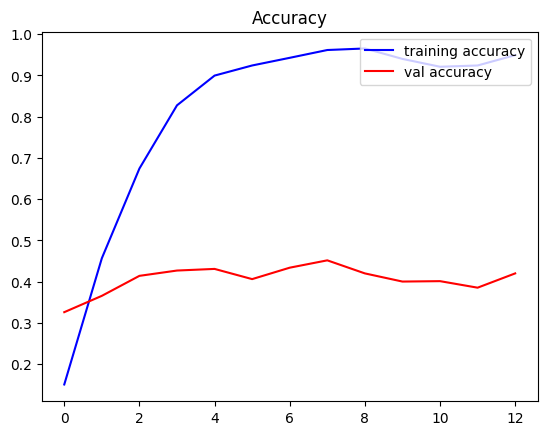

In [ ]:
fig = plt.figure()
plt.plot(results.history['accuracy'], c='blue', label='training accuracy')
plt.plot(results.history['val_accuracy'], c='red', label='val accuracy')
plt.title('Accuracy')
plt.legend(loc='upper right')
plt.show()

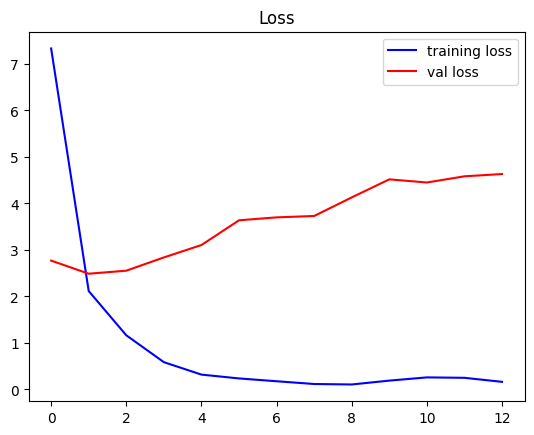

In [ ]:
fig = plt.figure()
plt.plot(results.history['loss'], c='blue', label='training loss')
plt.plot(results.history['val_loss'], c='red', label='val loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.show()